# SEVIR Weather Radar Prediction

This notebook builds, trains, and evalutates a neural network model to predict frames of weather radar from GOES satellite imagery. The SEVIR dataset was chosen since it is machine learning ready, and contains the desired data in a segmented and annotated format. The model will predict independent frames and will ignore the temporal axis of this dataset. 

## Setup Data Source

We can use the sevir generator from the MIT repository for pulling data for the model.

In [1]:
import warnings
warnings.filterwarnings("ignore")

CATALOG   = r"D:/Data_Science/SEVIR/CATALOG.csv"
DATA_HOME = r"D:/Data_Science/SEVIR/data"

import sys
sys.path.append('eie-sevir')

In [2]:
import time
import datetime
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import seaborn as sns

from sevir.generator import SEVIRGenerator # The Pytorch generator doesn't seem to be complete
from sevir.display import get_cmap

from sklearn.linear_model import LinearRegression

import torch; torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
from pytorch_models import UNet, ConvNet, EarlyStopper

device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [3]:
# Train on 2018 data, test on 2019 data

train_generator = SEVIRGenerator(
    x_img_types=['vis','ir069','ir107','lght'],
    y_img_types=['vil'],
    batch_size=64,
    unwrap_time=True,
    shuffle=True, 
    catalog=CATALOG, 
    sevir_data_home=DATA_HOME,
    start_date=datetime.datetime(2018,1,1),
    end_date=datetime.datetime(2019,1,1),
)

test_generator = SEVIRGenerator(
    x_img_types=['vis','ir069','ir107','lght'],
    y_img_types=['vil'],
    batch_size=64,
    unwrap_time=True,
    catalog=CATALOG, 
    sevir_data_home=DATA_HOME,
    start_date=datetime.datetime(2019,1,1),
    end_date=datetime.datetime(2020,1,1),
)

## Pixel-Based Linear Regression

The simplest possible model is a linear regression that predicts each pixel of the radar frame independently. 

We will first need to re-scale the image data spatially. The vis channel has to be downscaled 2x, ir069 and ir107 upscaled 2x, and lght upscaled 8x.

In [4]:
# Load a portion of the data - for the simple model, we will just take a sample

train_data = train_generator.load_batches(n_batches=10, progress_bar=True)

## Data structure:
# 1st level: 0: X, 1: y
# 2nd level: channel - y has 1 channel, x has 4
# 3rd level: T by H by W by 1 image frames of each channel

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [04:12<00:00, 25.23s/it]


In [5]:
def rescale_SEVIR_X_stack(train_data, flatten=False):
    # Given SEVIRGenerator generated batches of vis, ir069, ir107, and lght data, rescale so that the image dimensions match
    n_frames = train_data[0][0].shape[0]
    
    if flatten:
        rescale_data = np.stack(
            [train_data[0][0].reshape((n_frames, 384, 2, 384, 2, 1)).max(4).max(2).flatten(), # Downsample ch 0 by 2
             train_data[0][1].repeat(2, axis=1).repeat(2, axis=2).flatten(), # Upsample ch 1 by 2
             train_data[0][2].repeat(2, axis=1).repeat(2, axis=2).flatten(), # Upsample ch 2 by 2
             train_data[0][3].repeat(8, axis=1).repeat(8, axis=2).flatten(), # Upsample ch 3 by 8
            ],
            axis=-1
        )
    else:
        rescale_data = np.stack(
            [train_data[0][0].reshape((n_frames, 384, 2, 384, 2, 1)).max(4).max(2), # Downsample ch 0 by 2
             train_data[0][1].repeat(2, axis=1).repeat(2, axis=2), # Upsample ch 1 by 2
             train_data[0][2].repeat(2, axis=1).repeat(2, axis=2), # Upsample ch 2 by 2
             train_data[0][3].repeat(8, axis=1).repeat(8, axis=2), # Upsample ch 3 by 8
            ],
            axis=-1
        )
    return rescale_data

In [6]:
pixel_x_data = rescale_SEVIR_X_stack(train_data, flatten=True)
pixel_y_data = train_data[1][0].flatten()

print(f" {pixel_y_data.shape} pixels to process.")

 (94371840,) pixels to process.


In [7]:
linear_model = LinearRegression()
reg = linear_model.fit(pixel_x_data, pixel_y_data)
pixel_y_pred = reg.predict(pixel_x_data)
pred_data = pixel_y_pred.reshape(train_data[1][0].shape)

print(f"The R^2 of the model was {reg.score(pixel_x_data, pixel_y_data)}. The coefficients for the data types were: \n'vis': {reg.coef_[0]}\n'ir069', {reg.coef_[1]}\n'ir107', {reg.coef_[2]}\n'lght' {reg.coef_[3]}")

The R^2 of the model was 0.2745532497997478. The coefficients for the data types were: 
'vis': 0.001474604053178764
'ir069', -0.0013999822589294024
'ir107', -0.006328478439313052
'lght' 8.978196221694843


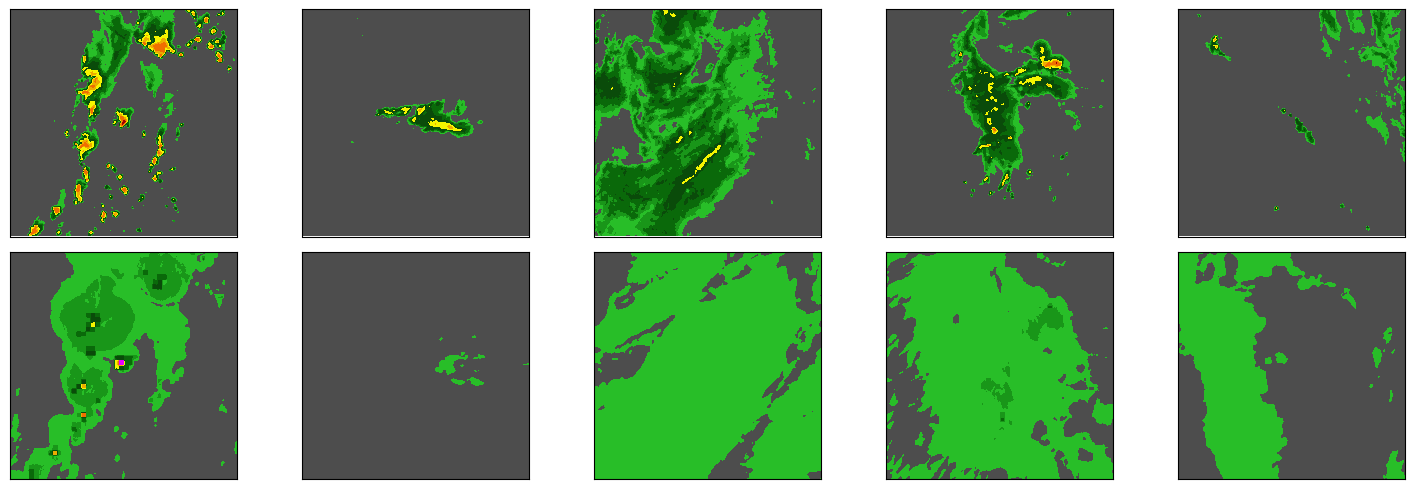

In [8]:
# View some predicted frames

fig, axs = plt.subplots(2, 5, figsize=(15, 5))
cmap, norm, vmin, vmax = get_cmap('vil')
for i in range(5):
    axs[0, i].imshow(train_data[1][0][i,:,:,:], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    axs[0, i].set_xticks([], [])
    axs[0, i].set_yticks([], [])

    axs[1, i].imshow(pred_data[i,:,:,:], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    axs[1, i].set_xticks([], [])
    axs[1, i].set_yticks([], [])

plt.tight_layout()

This is an ok start, but we can clearly predict the radar more accurately than this. Notably, the lightning coefficient is by far the largest. Lightning strikes seem to be a strong predictor of heavy localized rain. For the more complicated model, the presence of lightning strikes close by will likely be an important driver in determining radar imagery.

## UNet Model

Try using a UNet model as demonstrated in https://towardsdatascience.com/cook-your-first-u-net-in-pytorch-b3297a844cf3.

In order for the structure of the model to work correctly, we will have to trim all data to 380x380 size from 384x384 size. Only certain sizes will work with the current model configuration.

Since we're using Pytorch to build the model, we will have to manually supply the data instead of using a Pytorch data generator. We will load a few GB's of data at a time, transfer to the GPU, run the training step, and repeat these steps for each epoch. This will make the training loop slower but we can take advantage of the dataloader from the MIT repository. 

In [9]:
def scale_sevir_data(data, sevir_dtypes): # Scale SEVIR data (n by w by h by dim) to 0-1
    if len(sevir_dtypes) != data.shape[3]:
        return -1  # Did not specify the SEVIR data types correctly

    scaled_data = np.zeros_like(data).astype(float)
    for i, sevir_dtype in enumerate(sevir_dtypes):
        _,_,vmin,vmax = get_cmap(sevir_dtype, encoded=True) # Assume encoded
        scale_factor = 1 / (vmax - vmin)
        clipped_data = np.clip(data[:,:,:,i], a_min=vmin, a_max=vmax)
        
        # Scale the array
        scaled_data[:,:,:,i] = (clipped_data - vmin) * scale_factor

    return scaled_data


def preprocess_sevir_data(sevir_data_batches, device, droplast=True):
    ## This function takes the output of a SEVIRGenerator load_batches call and prepares the data for Pytorch training steps
    # 1) Rescale the resolutions to match the vil images
    # 2) Clip the data based on the colormap generator and 0-1 scale
    # 3) Load the data to GPU tensors and create a dataloader

    image_x_data = rescale_SEVIR_X_stack(sevir_data_batches, flatten=False).squeeze()
    image_y_data = sevir_data_batches[1][0]
    
    # Scale the data with the scalings provided in the sevir repo
    sevir_dtypes = ['vis','ir069','ir107','lght']  # Order of data types
    image_x_data = scale_sevir_data(image_x_data, sevir_dtypes)
    image_y_data = np.clip(image_y_data, 0, 255).astype(float)/255 # The vil data is always between 0 and 255

    # Convert dataframes to tensors
    input_tensor = torch.tensor(image_x_data, dtype=torch.float, device=device).permute(0, 3, 1, 2) # n_batch, w, h, n_ch --> n_batch, n_ch, w, h
    target_tensor = torch.tensor(image_y_data, dtype=torch.float, device=device).permute(0, 3, 1, 2)
    
    # Create a TensorDataset and DataLoader
    dataset = TensorDataset(input_tensor, target_tensor)
    dataloader = DataLoader(dataset, batch_size=8, drop_last=droplast)

    return dataloader

In [10]:
model_unet = UNet(in_channels=4, out_channels=1, init_features=16).to(device)
model_conv = ConvNet(in_channels=4, out_channels=1, kernel=7, padding=3).to(device)

criterion = nn.MSELoss()
optimizer_unet = torch.optim.Adam(model_unet.parameters(), lr=0.0001)
optimizer_conv = torch.optim.Adam(model_conv.parameters(), lr=0.0001)

n_epochs = 100
n_batches = 10 # Number of batches to load at a time

learning_df_unet = pd.DataFrame(index=np.arange(n_epochs)+1, columns=['Train_Loss', 'Valid_Loss'])
learning_df_conv = pd.DataFrame(index=np.arange(n_epochs)+1, columns=['Train_Loss', 'Valid_Loss'])

best_loss_unet = np.inf
best_loss_conv = np.inf

In [11]:
# Validation dataset - first batch of test data (offset 0)
valid_data = test_generator.load_batches(n_batches=n_batches, offset=0)
valid_dataloader = preprocess_sevir_data(valid_data, device='cpu')

In [13]:
# Training loop
model_id = datetime.datetime.now().strftime("%m-%d-%Y--%H%M%S")
start_time = time.time()

for epoch in range(n_epochs):
    model_unet.train()
    model_conv.train()
    
    train_loss_unet = 0
    valid_loss_unet = 0

    train_loss_conv = 0
    valid_loss_conv = 0
    
    # Double training loop - cannot load all data at once
    offsets = np.random.randint(0, len(train_generator) - n_batches - 5, size=20, dtype=int) # Load random batches
    for i in offsets:
        train_data = train_generator.load_batches(n_batches=n_batches, offset=i)
        dataloader = preprocess_sevir_data(train_data, device='cpu')

        for (inputs, targets) in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            
            optimizer_unet.zero_grad()
            optimizer_conv.zero_grad()
            
            outputs_unet = model_unet(inputs)
            outputs_conv = model_conv(inputs)
            
            loss_unet = criterion(outputs_unet, targets)
            loss_conv = criterion(outputs_conv, targets)
            
            loss_unet.backward()
            loss_conv.backward()
            
            optimizer_unet.step()
            optimizer_conv.step()
            
            train_loss_unet += loss_unet.item()
            train_loss_conv += loss_conv.item()

    # Validation
    model_unet.eval()
    model_conv.eval()
    
    for (inputs, targets) in valid_dataloader:
        inputs, targets = inputs.to(device), targets.to(device)
        
        optimizer_unet.zero_grad()
        optimizer_conv.zero_grad()
        
        outputs_unet = model_unet(inputs)
        outputs_conv = model_conv(inputs)
        
        loss_unet = criterion(outputs_unet, targets)
        loss_conv = criterion(outputs_conv, targets)
        
        valid_loss_unet += loss_unet.item()
        valid_loss_conv += loss_conv.item()
    
    learning_df_unet.loc[epoch+1] = [train_loss_unet, valid_loss_unet]
    learning_df_conv.loc[epoch+1] = [train_loss_conv, valid_loss_conv]
    
    print(f'Epoch: {epoch+1}, Train_Loss_Unet: {train_loss_unet}, Valid_Loss_Unet: {valid_loss_unet}, Train_Loss_Conv: {train_loss_conv}, Valid_Loss_Conv: {valid_loss_conv}')

    if valid_loss_unet < best_loss_unet: # Save the model if loss improved
        best_loss_unet = valid_loss_unet
        torch.save(model_unet.state_dict(), f'models/UNet_{model_id}_best.pt') 

    if valid_loss_conv < best_loss_conv: # Save the model if loss improved
        best_loss_conv = valid_loss_conv
        torch.save(model_conv.state_dict(), f'models/ConvNet_{model_id}_best.pt') 
        
    torch.save(model_unet.state_dict(), f'models/UNet_{model_id}_epoch_{epoch}.pt') 
    torch.save(model_conv.state_dict(), f'models/ConvNet_{model_id}_epoch_{epoch}.pt') 


end_time = time.time()
time_elapsed = end_time - start_time # Time in seconds
print(f"Time elapsed is {time_elapsed} seconds")

learning_df_unet.to_csv(f"models/loss_unet_{model_id}.csv") # Save loss data
learning_df_conv.to_csv(f"models/loss_conv_{model_id}.csv") # Save loss data

Epoch: 1, Train_Loss_Unet: 108.98695391230285, Valid_Loss_Unet: 2.081046039238572, Train_Loss_Conv: 62.466101641301066, Valid_Loss_Conv: 1.231982892146334
Epoch: 2, Train_Loss_Unet: 30.737973319366574, Valid_Loss_Unet: 1.4313411717303097, Train_Loss_Conv: 26.465701091568917, Valid_Loss_Conv: 0.8730827905237675
Epoch: 3, Train_Loss_Unet: 22.617579815443605, Valid_Loss_Unet: 0.6125419910531491, Train_Loss_Conv: 27.6436114651151, Valid_Loss_Conv: 0.8192584318458103
Epoch: 4, Train_Loss_Unet: 19.436219611670822, Valid_Loss_Unet: 0.524833724135533, Train_Loss_Conv: 26.86950658238493, Valid_Loss_Conv: 0.8055389533983544
Epoch: 5, Train_Loss_Unet: 17.5156839909032, Valid_Loss_Unet: 0.5654067914292682, Train_Loss_Conv: 25.567141990177333, Valid_Loss_Conv: 0.8248527881223708
Epoch: 6, Train_Loss_Unet: 17.780719075351954, Valid_Loss_Unet: 0.4750092654430773, Train_Loss_Conv: 26.317327853757888, Valid_Loss_Conv: 0.8327644480741583
Epoch: 7, Train_Loss_Unet: 16.55155779281631, Valid_Loss_Unet: 0.5

KeyboardInterrupt: 

In [14]:
learning_df_unet.to_csv(f"models/loss_unet_{model_id}.csv") # Save loss data
learning_df_conv.to_csv(f"models/loss_conv_{model_id}.csv") 

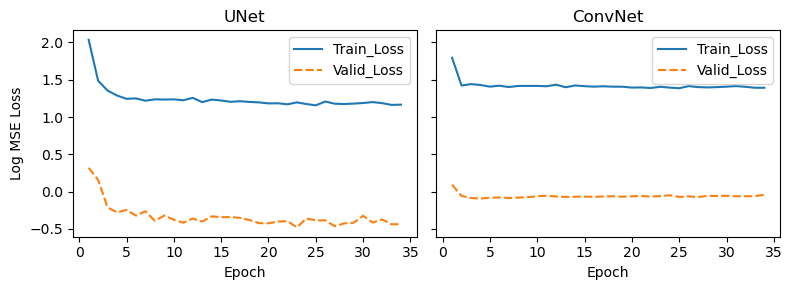

In [16]:
# Plot the training performance
# TODO Load both model types

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)

sns.lineplot(ax=axs[0], data=learning_df_unet.astype(float).apply(np.log10)).set_title('UNet')
sns.lineplot(ax=axs[1], data=learning_df_conv.astype(float).apply(np.log10)).set_title('ConvNet')

axs[0].set_xlabel('Epoch')
axs[1].set_xlabel('Epoch')

axs[0].set_ylabel('Log MSE Loss')
axs[1].set_ylabel('Log MSE Loss')

plt.tight_layout()

In [12]:
# Reload the best models and evaluate
model_id = '04-07-2024--133301'
model_conv.load_state_dict(torch.load(f'models/ConvNet_{model_id}_best.pt'))
model_unet.load_state_dict(torch.load(f'models/UNet_{model_id}_best.pt'))

model_conv.eval()
model_unet.eval()

test_data = train_generator.load_batches(n_batches=1, progress_bar=True, offset=20)
testloader = preprocess_sevir_data(test_data, device='cpu')

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:25<00:00, 25.65s/it]


In [13]:
# Linear model prediction

pixel_x_data = rescale_SEVIR_X_stack(test_data, flatten=True)
pixel_y_pred = reg.predict(pixel_x_data)
pred_lin = pixel_y_pred.reshape(test_data[1][0].shape)

In [14]:
# Neural network predictions

np_outputs_conv = []
np_outputs_unet = []

for (inputs, targets) in testloader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs_unet = model_unet(inputs)
    outputs_conv = model_conv(inputs)

    outputs_unet = outputs_unet.permute(0, 2, 3, 1).cpu().detach().numpy()
    outputs_conv = outputs_conv.permute(0, 2, 3, 1).cpu().detach().numpy()
    
    np_outputs_conv.append(outputs_conv)
    np_outputs_unet.append(outputs_unet)

pred_conv = (np.concatenate(np_outputs_conv)*255).astype(int)
pred_unet = (np.concatenate(np_outputs_unet)*255).astype(int)

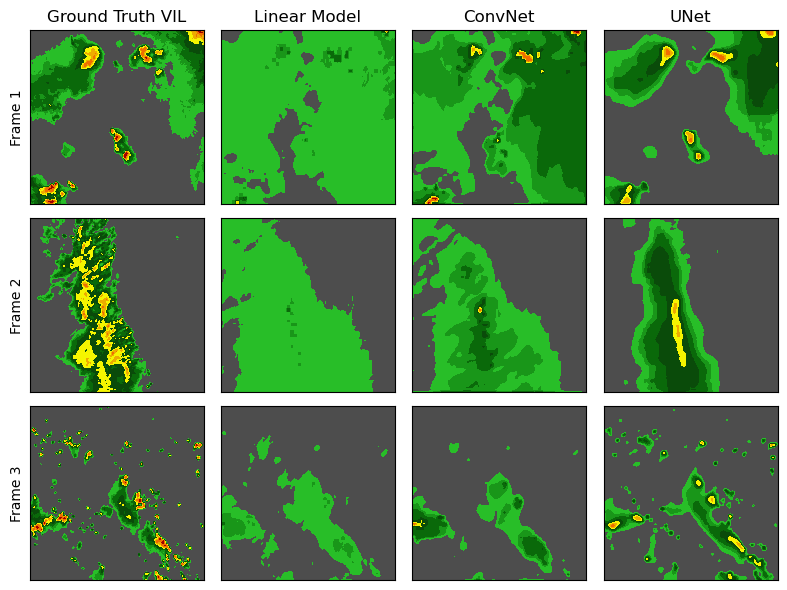

In [33]:
# View some predicted frames from the model

fig, axs = plt.subplots(3, 4, figsize=(8, 6))
cmap, norm, vmin, vmax = get_cmap('vil')

frames = [1,3,4]

for i in range(3):
    axs[i, 0].imshow(test_data[1][0][frames[i],:,:,:], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    axs[i, 1].imshow(pred_lin[frames[i],:,:,:], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    axs[i, 2].imshow(pred_conv[frames[i],:,:,:], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)
    axs[i, 3].imshow(pred_unet[frames[i],:,:,:], cmap=cmap, norm=norm, vmin=vmin, vmax=vmax)

for ax in axs.ravel():
    ax.set_xticks([], [])
    ax.set_yticks([], [])

axs[0, 0].set_title('Ground Truth VIL')
axs[0, 1].set_title('Linear Model')
axs[0, 2].set_title('ConvNet')
axs[0, 3].set_title('UNet')

axs[0, 0].set_ylabel('Frame 1')
axs[1, 0].set_ylabel('Frame 2')
axs[2, 0].set_ylabel('Frame 3')

plt.tight_layout()

## Generate Final Radar Gif

Use our best model (UNet) to generate a predicted radar sequence for a series of radar frames. Along with the input data sources from GOES, generate a Gif of the sequence.

In [19]:
train_generator.close()
test_generator.close()

video_generator = SEVIRGenerator(
    x_img_types=['vis','ir069','ir107','lght'],
    y_img_types=['vil'],
    batch_size=1, 
    catalog=CATALOG, 
    sevir_data_home=DATA_HOME
)

In [20]:
video_data = video_generator.get_batch(800)

In [21]:
# Reshape the video data
for i in range(len(video_data[0])):
    video_data[0][i] = np.transpose(video_data[0][i], (3, 1, 2, 0))
video_data[1][0] = np.transpose(video_data[1][0], (3, 1, 2, 0))

video_dataloader = preprocess_sevir_data(video_data, device='cpu', droplast = False)

In [23]:
# Neural network predictions

unet_video = []

for (inputs, targets) in video_dataloader:
    inputs, targets = inputs.to(device), targets.to(device)
    
    outputs_unet = model_unet(inputs)
    outputs_unet = outputs_unet.permute(0, 2, 3, 1).cpu().detach().numpy()
    unet_video.append(outputs_unet)

unet_video = (np.concatenate(unet_video)*255).astype(int)

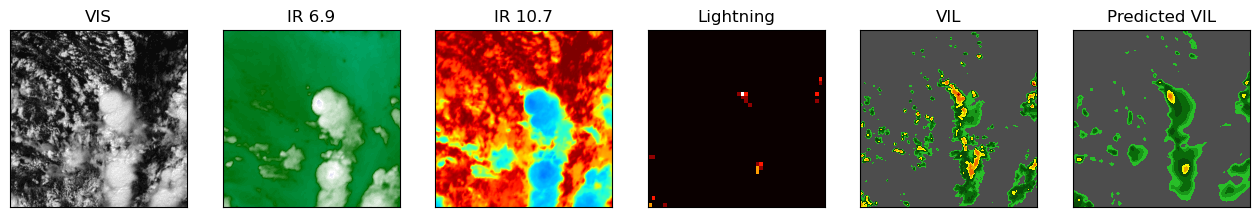

In [29]:
# Define the function to update the frames
def update(i):
    axs[0].imshow(video_data[0][0][i,:,:,:], cmap=vis_cmap, vmin=vis_vmin, vmax=vis_vmax)
    axs[1].imshow(video_data[0][1][i,:,:,:], cmap=ir069_cmap, norm=ir069_norm, vmin=ir069_vmin, vmax=ir069_vmax)
    axs[2].imshow(video_data[0][2][i,:,:,:], cmap=ir107_cmap, norm=ir107_norm, vmin=ir107_vmin, vmax=ir107_vmax)
    axs[3].imshow(video_data[0][3][i,:,:,:], cmap=lght_cmap, norm=lght_norm, vmin=lght_vmin, vmax=lght_vmax)
    axs[4].imshow(video_data[1][0][i,:,:,:], cmap=vil_cmap, norm=vil_norm, vmin=vil_vmin, vmax=vil_vmax)
    axs[5].imshow(unet_video[i,:,:,:], cmap=vil_cmap, norm=vil_norm, vmin=vil_vmin, vmax=vil_vmax)
    
    axs[0].set_title('VIS')
    axs[1].set_title('IR 6.9')
    axs[2].set_title('IR 10.7')
    axs[3].set_title('Lightning')
    axs[4].set_title('VIL')
    axs[5].set_title('Predicted VIL')

# Create the figure and axes
fig, axs = plt.subplots(1, 6, figsize=(16, 6))

# Remove the ticks
for ax in axs.ravel():
    ax.set_xticks([], [])
    ax.set_yticks([], [])

# Create the animation
ani = FuncAnimation(fig, update, frames=range(49), blit=False)

# Save the animation as a GIF
ani.save('animation.gif', writer='pillow', fps=10)